In [16]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\josep\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
reports = pd.read_csv(r'../../data/tcga_pathology/raw/tcga_pathology_reports.csv')
cancer_type = pd.read_csv(r'../../data/tcga_pathology/raw/tcga_patient_to_cancer_type.csv')

## Check First Few Examples

In [4]:
reports.head()

,patient_filename,text
0,TCGA-BP-5195.25c0b433-5557-4165-922e-2c1eac9c26f0,Date of Recelpt: Clinical Diagnosis & History:...
1,TCGA-D7-8573.b7306a47-697d-4ed3-bbe1-81d49674a8f8,"Material: 1) Material: stomach, Method of coll..."
2,TCGA-EI-7004.13591eed-30e5-47a3-91be-7a370663d2d4,page 1 / 1. copy No. 3. Examination: Histopath...
3,TCGA-EB-A82B.23E186C6-739C-4EF1-8788-79AA89C6E87A,Patient ID: Gross Description: A mass is locat...
4,TCGA-A6-3808.e1505f65-72ef-438d-a5e1-93ed8bf6635d,SPECIMEN. Right colon. CLINICAL NOTES. PRE-OP ...


In [5]:
cancer_type.head()

,patient_id,cancer_type
0,TCGA-OR-A5J1,ACC
1,TCGA-OR-A5J2,ACC
2,TCGA-OR-A5J3,ACC
3,TCGA-OR-A5J4,ACC
4,TCGA-OR-A5J5,ACC


## High Level Statistics

In [6]:
reports.describe()

,patient_filename,text
count,9523,9523
unique,9523,9505
top,TCGA-AA-3538.32912174-66b8-4144-9ef0-26b04c05e568,Neuropathology. Commentary: Histology and morp...
freq,1,3


In [7]:
cancer_type.cancer_type.describe()

count     11160
unique       33
top        BRCA
freq       1097
Name: cancer_type, dtype: object

In [8]:
print(set(cancer_type.cancer_type))

{'UVM', 'MESO', 'OV', 'LIHC', 'SKCM', 'KIRC', 'READ', 'PCPG', 'THCA', 'BLCA', 'PRAD', 'UCEC', 'ACC', 'ESCA', 'GBM', 'COAD', 'KICH', 'LGG', 'LUAD', 'PAAD', 'BRCA', 'CHOL', 'SARC', 'KIRP', 'LAML', 'STAD', 'DLBC', 'THYM', 'CESC', 'HNSC', 'LUSC', 'TGCT', 'UCS'}


## Check Missing Data

In [9]:
reports.isna().sum()

patient_filename    0
text                0
dtype: int64

In [10]:
cancer_type.isna().sum()

patient_id     0
cancer_type    0
dtype: int64

## Visualize Common Words Per Cancer Type

In [11]:
## combine datasets
reports['patient_id'] = reports['patient_filename'].str.split('.').str[0]
data = reports.merge(cancer_type, on='patient_id')

In [12]:
# Download stopwords if not already

stop_words = set(stopwords.words('english'))

def top_words_per_cancer(data, cancer_types, text_col='text', label_col='cancer_type', top_n=20):
    """
    Returns a DataFrame with top N words and counts for each cancer type.
    """
    rows = []

    for ct in cancer_types:
        subset = data[data[label_col] == ct]
        text = " ".join(subset[text_col].tolist()).lower()
        words = [word for word in text.split() if word not in stop_words]

        counter = Counter(words)
        most_common = counter.most_common(top_n)

        # Flatten top words and counts into a single row
        row = {'cancer_type': ct}
        for i, (word, count) in enumerate(most_common, start=1):
            row[f'word_{i}'] = word

        rows.append(row)

    df_top_words = pd.DataFrame(rows)
    return df_top_words

# Usage
cancer_types = {'READ', 'KIRC', 'PCPG', 'BRCA', 'LUAD', 'LUSC', 'UCS', 'COAD',
                'KIRP', 'LAML', 'BLCA', 'UCEC', 'TGCT', 'UVM', 'SARC', 'THYM',
                'PRAD', 'MESO', 'HNSC', 'OV', 'ACC', 'GBM', 'STAD', 'PAAD', 'CESC',
                'KICH', 'THCA', 'DLBC', 'ESCA', 'SKCM', 'CHOL', 'LGG', 'LIHC'}

df_top_words = top_words_per_cancer(data, cancer_types)
df_top_words.head()

,cancer_type,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,...,word_11,word_12,word_13,word_14,word_15,word_16,word_17,word_18,word_19,word_20
0,UVM,tumour,optic,tumor,mm,the.,nerve,no.,melanoma,clinical,...,choroidal,anterior,x,report.,melanoma.,right,ciliary,cells,cell,tumor.
1,MESO,x,lymph,specimen,tissue,cm,submitted,tumor,consists,malignant,...,received,-,labeled,level,part,cm.,measuring,sections,one,node
2,OV,x,cm,-,tumor,lymph,fallopian,serous,labeled,cm.,...,tissue,left,tube,ovary,measuring,specimen,surface,papillary,sections,metastatic
3,LIHC,x,tumor,liver,cm,-,specimen,no.,hepatocellular,cm.,...,:,resection,invasion:,lymph,mass,segment,"liver,",gross,a.,the.
4,SKCM,tumor,lymph,specified.,x,skin,melanoma.,-,specimen,node,...,tissue,invasion:,melanoma,cm.,type:,sentinel,left,n/a.,histologic,description:


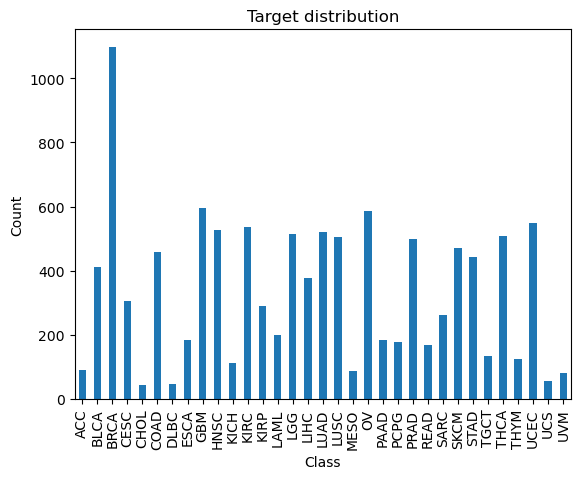

In [18]:
cancer_type.cancer_type.value_counts().sort_index().plot(kind='bar')
plt.title("Target distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()